In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual

import os

## Read the dataset

In [2]:
from dataloaders.germany_dataset import load_image_and_labels
from image_helpers import polygons_to_bounding_boxes, polygons_to_masks, mask_to_polygons
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes
from torchvision.tv_tensors import BoundingBoxes, Mask

In [3]:
def plot_image_and_mask(image, masks):
    # Convert images to uint8
    image = (image * 255).byte()
    
    # Convert masks to bool
    masks = masks.bool()
    
    # Draw the masks on the image
    image_with_masks = draw_segmentation_masks(image, masks)
    
    # Convert to PIL image
    image_with_masks = image_with_masks.permute(1, 2, 0).numpy()
    
    # Plot the image
    plt.imshow(image_with_masks)
    plt.show()
    

In [4]:
from dataloaders.solar_dk_dataset import SolarDKDataset
import torchvision.transforms.v2 as transforms

train_folder = "data/solardk_dataset_neurips_v2/gentofte_trainval/train"
validation_folder = "data/solardk_dataset_neurips_v2/gentofte_trainval/val"

transform = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ToDtype(torch.float32),
])

train_dataset = SolarDKDataset(train_folder, transform=transform)
validation_dataset = SolarDKDataset(validation_folder, transform=transform)

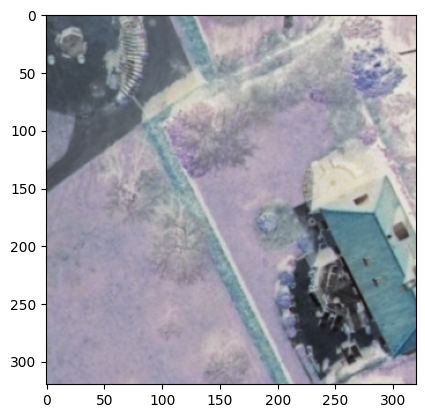

In [5]:
image, mask = train_dataset[10698]
plot_image_and_mask(image, mask)

### Load the dataset

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
validation_dataset = DataLoader(validation_dataset, batch_size=4, shuffle=False, num_workers=4)

### Train the model

In [7]:
import pytorch_lightning as pl
from models.base import BaseModel
from models.architectures.deep_lab import DeepLabModel
# from models.architectures.mask_rcnn import MaskRCNNModel
from models.architectures.unet import UNetModel

In [8]:
model = DeepLabModel(num_classes=1)
# model = UNetModel(n_channels=3, n_classes=1)

# model = MaskRCNNModel(num_classes=1)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

base_model = BaseModel(model, loss_fn, optimizer)
trainer = pl.Trainer(max_epochs=10, min_epochs=5)

/home/tue/20231335/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/tue/20231335/InterdisciplinaryProject/.venv/li ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
for image, label in train_dataloader:
    # Print the size of the image and label
    print(image.size(), label.size())  
    break

torch.Size([4, 3, 320, 320]) torch.Size([4, 1, 320, 320])


In [10]:
# trainer.fit(base_model, train_dataloaders=train_dataloader, val_dataloaders=validation_dataset)

TypeError: Invalid shape (1, 1, 320, 320) for image data

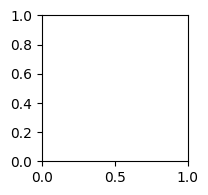

In [17]:
import torch
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt
from PIL import Image

model = DeepLabModel(num_classes=1)
model.load_state_dict(torch.load("DeepLabModel.pth"))

test_folder = "data/solardk_dataset_neurips_v2/herlev_test/test"

transform = transforms.Compose(
    [
        transforms.ToDtype(torch.float32),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_dataset = SolarDKDataset(test_folder, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Estimate the model on the test set
model.eval()
with torch.no_grad():
    for image, label in test_loader:
        output = model(image)[1]
    
        output_predictions = output.argmax(0) 
        label = label[1].squeeze()
        
        plt.subplot(1, 3, 2)
        plt.imshow(label, cmap="gray")
        plt.title("Label")
        
        plt.subplot(1, 3, 3)
        r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize((label.size(1), label.size(0)))
        plt.imshow(r, cmap="gray")
        plt.title("Output")
        
        plt.show()
        
        break
        